### Multi-Conditional Graph Variational Autoencoder

In [4]:
import torch
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [5]:
from data.dataset import QM9GraphDataset
from utils.datautils import create_data_loaders
from mgcvae import MGCVAE
from trainer import MGCVAETrainer
from utils.trainutils import load_from_checkpoint

In [6]:
dataset = QM9GraphDataset(csv_path='./data/qm9_bbbp.csv')

Processing...


Processing 2142 molecules...
Successfully processed 2142 molecules, failed: 0


Done!


In [7]:
train_loader, val_loader, test_loader = create_data_loaders(dataset, batch_size=4)

Dataset splits — Train: 1713, Val: 214, Test: 215


In [9]:
# Load the best model from training
model, checkpoint = load_from_checkpoint('checkpoints/mgcvae/best_model.pth', device=device)
loaded = True

# Model is ready for inference!
# You can also access training history:
print(f"\nTraining stopped at epoch: {checkpoint['epoch']}")
print(f"Final validation loss: {checkpoint['best_val_loss']:.4f}")

Model loaded from checkpoints/mgcvae/best_model.pth
Epoch: 10, Best Val Loss: 0.8748

Training stopped at epoch: 10
Final validation loss: 0.8748


### If we haven't Trained yet

In [11]:
if not loaded:
    model_config = {
        'node_dim': 29,
        'edge_dim': 6,
        'latent_dim': 32,
        'hidden_dim': 64,
        'num_properties': 1,
        'num_layers': 3,
        'heads': 4,
        'max_nodes': 20,
        'beta': 0.01,      # Start with low KL weight
        'gamma': 1.0,      # Property prediction weight
        'dropout': 0.1
    }
    model = MGCVAE(**model_config).to(device)

In [12]:
trainer = MGCVAETrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=1e-3,
    device=device,
    save_dir='checkpoints/mgcvae'
)

Starting MGCVAE training for 5 epochs
Model parameters: 105,216
Device: mps

Epoch 1/5


Validation: 100%|██████████| 54/54 [00:26<00:00,  2.02it/s]


New best model saved! Val loss: 0.8697
Train Loss: 0.9385 | Val Loss: 0.8697
Recon: 0.8251 | KL: 2.5548 | Prop: 0.0878
LR: 1.00e-03 | Patience: 0/30

Epoch 2/5


Validation: 100%|██████████| 54/54 [00:26<00:00,  2.04it/s]


New best model saved! Val loss: 0.8645
Train Loss: 0.9328 | Val Loss: 0.8645
Recon: 0.8210 | KL: 2.6408 | Prop: 0.0854
LR: 1.00e-03 | Patience: 0/30

Epoch 3/5


Validation: 100%|██████████| 54/54 [00:26<00:00,  2.04it/s]


Train Loss: 0.9205 | Val Loss: 0.8705
Recon: 0.8102 | KL: 2.5487 | Prop: 0.0848
LR: 1.00e-03 | Patience: 1/30

Epoch 4/5


Validation: 100%|██████████| 54/54 [00:29<00:00,  1.85it/s]


New best model saved! Val loss: 0.8522
Train Loss: 0.9145 | Val Loss: 0.8522
Recon: 0.8040 | KL: 2.6356 | Prop: 0.0842
LR: 1.00e-03 | Patience: 0/30

Epoch 5/5


Validation: 100%|██████████| 54/54 [00:25<00:00,  2.10it/s]


New best model saved! Val loss: 0.8495
Train Loss: 0.9099 | Val Loss: 0.8495
Recon: 0.7993 | KL: 2.7184 | Prop: 0.0834
LR: 1.00e-03 | Patience: 0/30


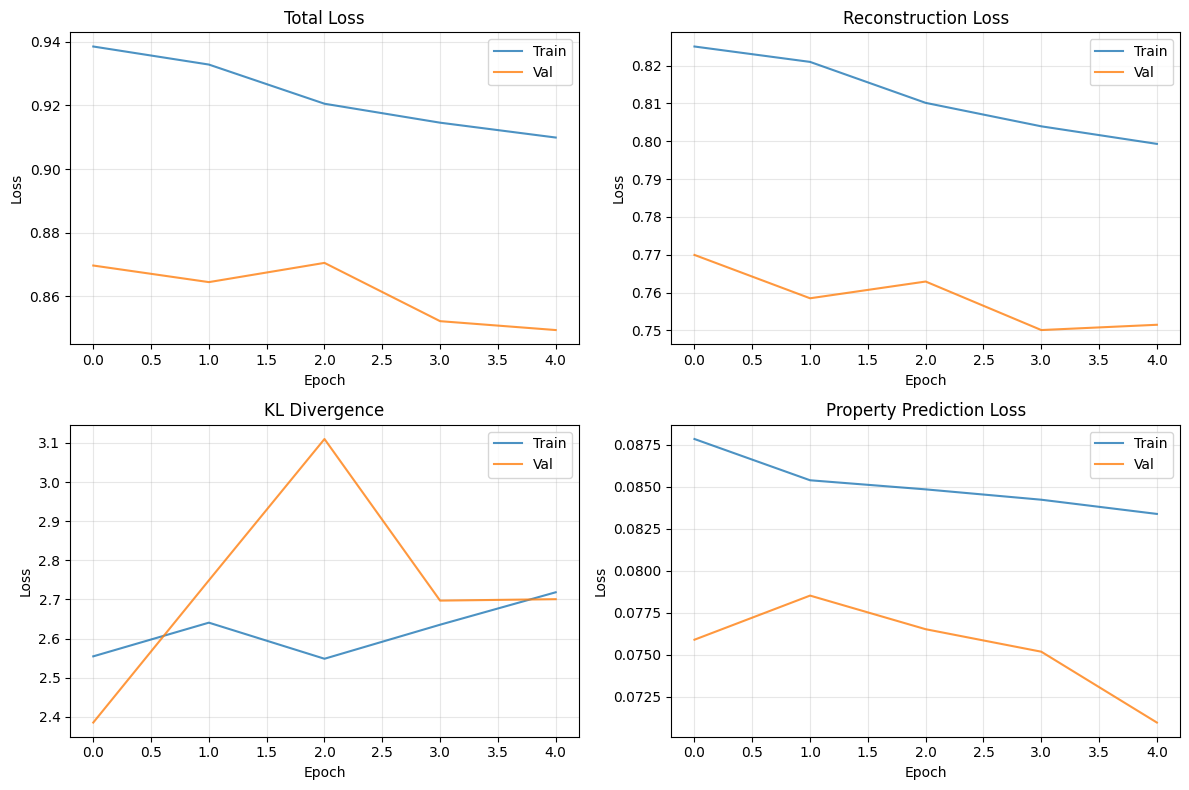

Training completed!


In [13]:
train_metrics, val_metrics = trainer.train(num_epochs=5)

### Metrics

In [1]:
from utils.metrics import (
    evaluate_property_prediction,
    evaluate_reconstruction_and_kl,
    evaluate_novelty_diversity,
    evaluate_conditioning_latent
)

In [3]:
from utils.inference import (
    batch_logits_to_molecules,
    evaluate_generation_quality
)